In [1]:
#Cài đặt thư viện
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.style.use("ggplot")
import numpy as np 
import pandas as pd 
import os
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error

In [2]:
#Data mining
def data_mining(data):
  from statsmodels.tsa.seasonal import seasonal_decompose
  result = seasonal_decompose(data, model='additive', period=20)
  #chuyển giá trị trên trục x nghiêng 45 độ
  result.observed.index = result.observed.index.strftime('%d-%m-%Y')
  #Tạo 4 subplots
  fig, ax = plt.subplots(4, 1, figsize=(10, 8))
  #Thực hiện gắn dữ liệu vào từng subplot
  result.observed.plot(ax=ax[0])
  ax[0].set_ylabel('Observed')
  result.trend.plot(ax=ax[1])
  ax[1].set_ylabel('Trend')
  result.seasonal.plot(ax=ax[2])
  ax[2].set_ylabel('Seasonal')
  result.resid.plot(ax=ax[3])
  ax[3].set_ylabel('Residual')
  plt.tight_layout()
  plt.show()

In [3]:
#Chia dữ liệu
def data_spliting(df1, train_ratio, test_ratio):
  train_size = int(train_ratio * len(df1))
  test_size = int(test_ratio * len(df1))
  val_size = len(df1) - train_size - test_size

  train_data = df1[:train_size]
  test_data = df1[train_size:train_size+test_size]
  val_data = df1[train_size+test_size:]

  return train_data, test_data, val_data

In [4]:
def visualize(label ,pred, model_name):
  plt.figure(figsize=(16,9))
  plt.plot(label, label = 'Ground truth')
  plt.plot(label.index, pred, label='Predict')
  plt.title(model_name)
  plt.xlabel('Date')
  plt.ylabel('Closing Price')
  plt.legend()
  plt.show()

In [5]:
#Visualization
def visualize_overview(train_data_df,test_data_df, val_data_df, test_predict_inverse, val_predict_inverse, model_name):

  plt.figure(figsize=(16,9))
  #train label
  plt.plot(train_data_df, label = 'Train')

  #test label and predict value
  plt.plot(test_data_df, label = 'Test')
  plt.plot(test_data_df.index, test_predict_inverse, label='Predict')

  #val label and predict value
  plt.plot(val_data_df, label = 'Validate')
  plt.plot(val_data_df.index, val_predict_inverse, label='ValidatePred')

  #predict next 30 days value
  # plt.plot(next30_predict_inverse, label = 'Predict30days')


  plt.title(model_name)
  plt.xlabel('Date')
  plt.ylabel('Closing Price')
  plt.legend()
  plt.show()

In [6]:
def mda_cal(actual: np.ndarray, predicted: np.ndarray):
    actual = actual.values
    predicted = predicted.values
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - actual[:-1])).astype(int))

In [7]:
#Đánh giá 
def deviation(test, pred):
  rmse=np.sqrt(mean_squared_error(test,pred))
  print(f"RMSE: {rmse:.2f}")
  mape=mean_absolute_percentage_error(test,pred)
  print(f"MAPE: {mape*100:.2f}%")
  mda = mda_cal(test, pred)
  print(f"MDA: {mda*100:.2f}%")

In [8]:
def arima_fit(train_data, test_data, val_data, model_name):
  fit_model = auto_arima(train_data, seasonal=False, trace=True)
  fit_model.summary()


  #dự đoán tập test
  test_predict = fit_model.predict(len(test_data))
  deviation(test_data, test_predict)
  visualize(test_data, test_predict, model_name)

  #dự đoán tập validate
  val_predict = fit_model.predict(len(val_data))
  deviation(val_data, val_predict)
  visualize(val_data, val_predict, model_name)





  # next30_predict_inverse = arima_next30days(model, scaler , y_val, val_data_df, time_step)
  visualize_overview(train_data, test_data, val_data, test_predict, val_predict, model_name)

In [9]:
#Chọn dataset, tỉ lệ và 
def data_preprocessing(data_src, train_ratio, test_ratio, model_name):
  df = pd.read_csv(data_src, parse_dates=True,
                       index_col=0).sort_values(by='Date', ascending=True)
  #Xóa dấu , và chuyển về float
  df['Price']=df['Price'].replace(',','',regex=True).astype(float)
  df['Open']=df['Open'].astype(str).str.replace(',','').astype(float)
  df['High']=df['High'].astype(str).str.replace(',','').astype(float)
  df['Low']=df['Low'].astype(str).str.replace(',','').astype(float)
  df['Change %']=df['Change %'].astype(str).str.replace('%','').astype(float)

  #Thực hiện tách chuỗi KL thành 1 chuỗi số float và 1 ký tự cuối sau đó lấy số float đó nhân với 1000 
  #nếu ký tự cuối là K, nếu là M thì nhân với 1000000, nếu không có K hay M thì trả về số float đó
  def convert_value(value):
      if isinstance(value, str):
          if value.endswith('K'):
              return float(value[:-1]) * 1000
          elif value.endswith('M'):
              return float(value[:-1]) * 1000000
          else:
              return float(value)
      else:
          return value

  df['Vol.'] = df['Vol.'].apply(convert_value)

  df = df[['Price']]

  data_mining(df)

  df1 = df
  
  train_data, test_data, val_data = data_spliting(df1,train_ratio, test_ratio)

  model =  arima_fit(train_data, test_data, val_data, model_name)


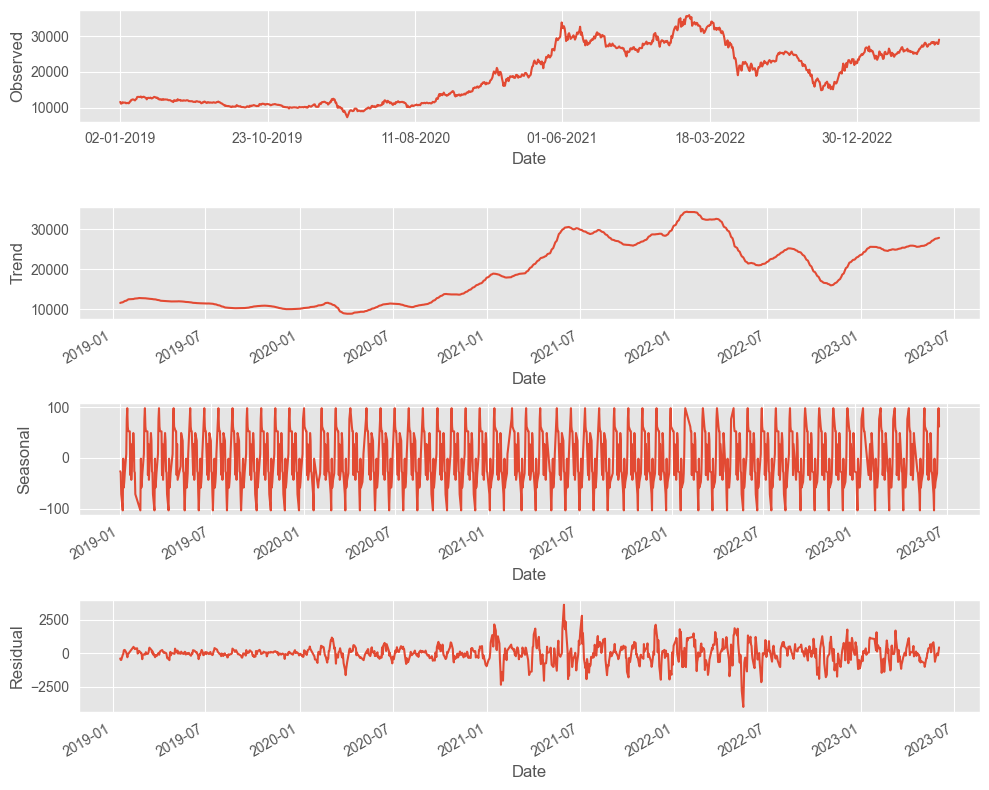

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9940.578, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9942.537, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9942.533, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9940.644, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9944.211, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.113 seconds
RMSE: 8934.60
MAPE: 33.16%
MDA: 48.38%


c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


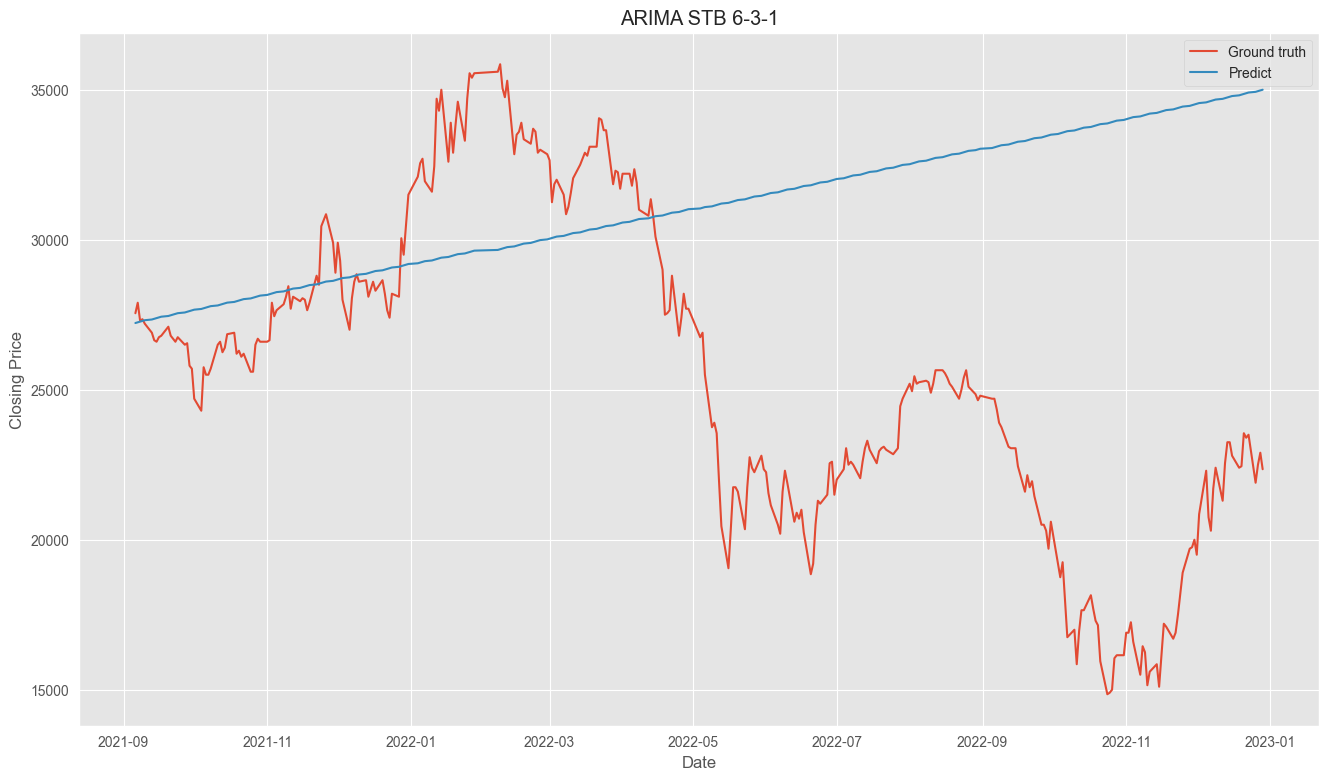

c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE: 2829.96
MAPE: 10.50%
MDA: 54.81%


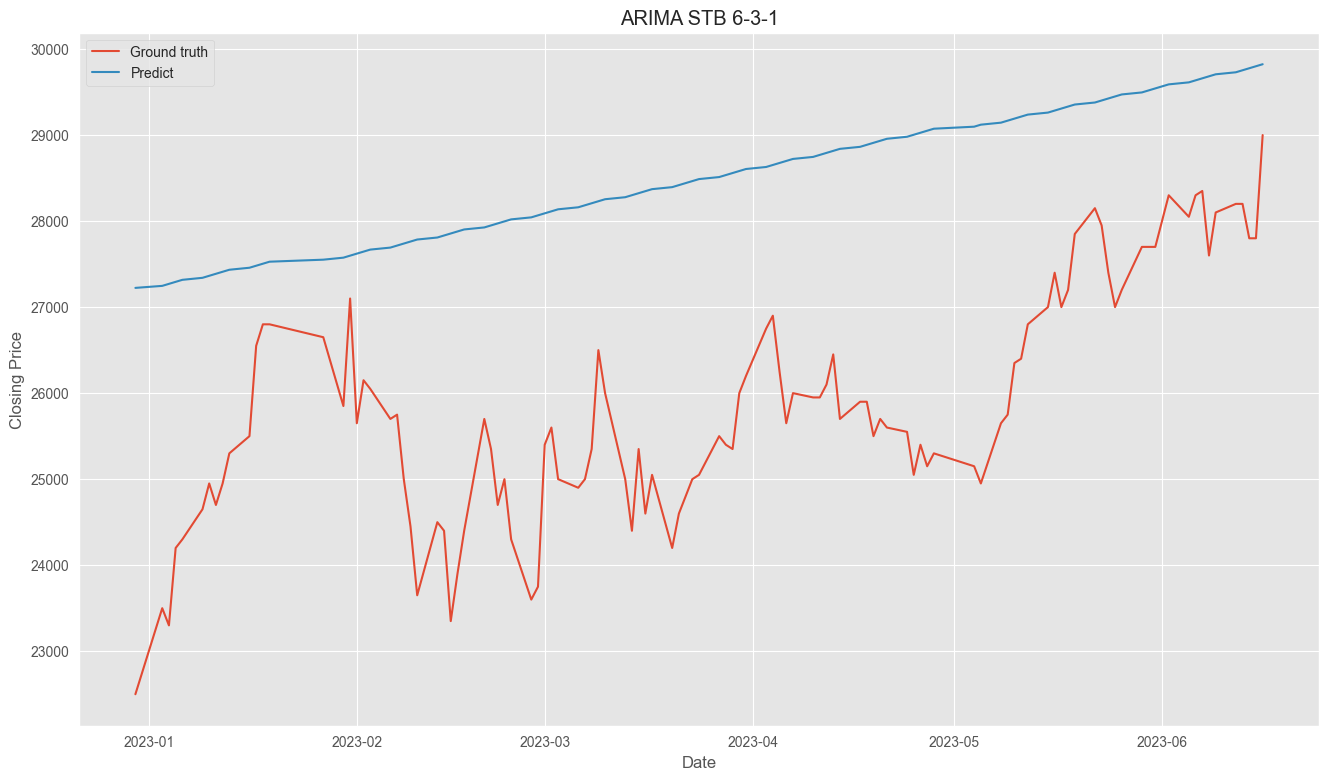

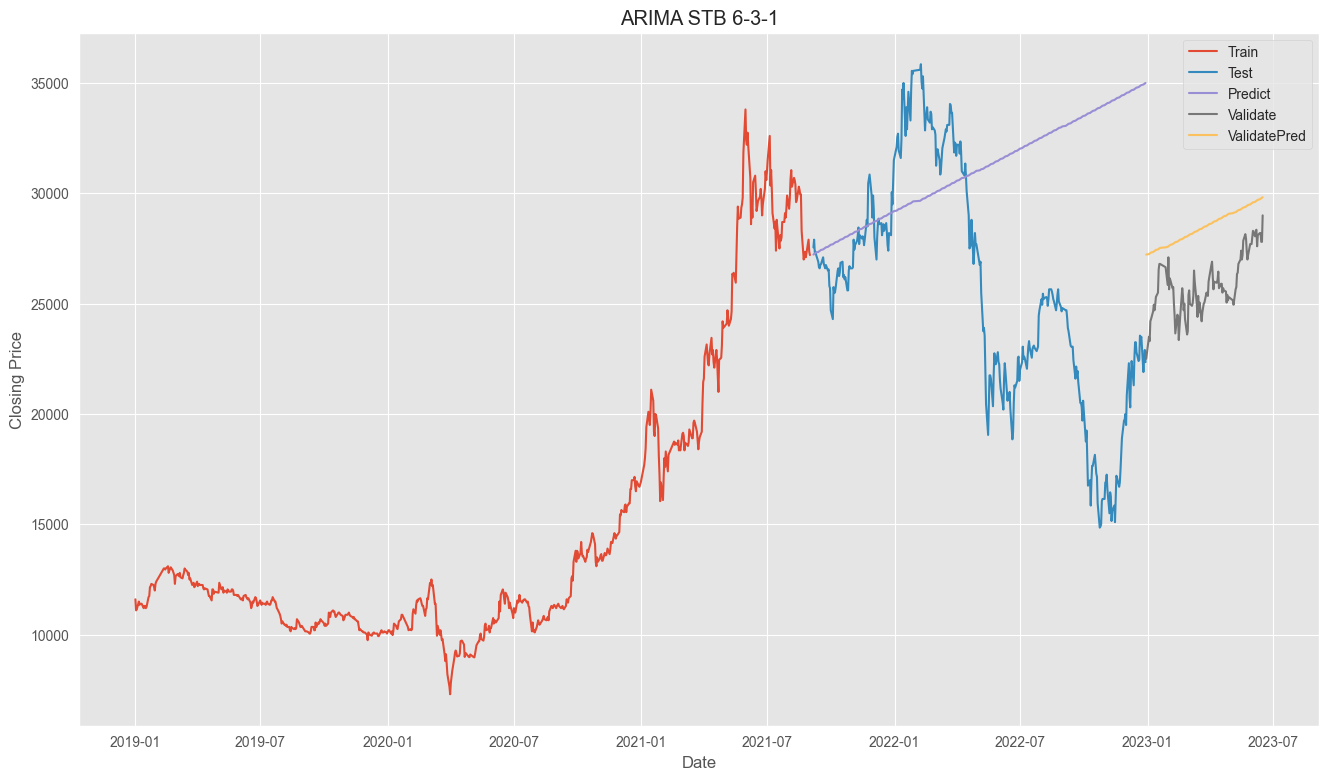

In [10]:
data_preprocessing('STB-Historical-Data.csv', 0.6, 0.3, "ARIMA STB 6-3-1")